# Exercício Prático 01 - Desenhos Abstratos


- **Author:** Gabriel Van Loon
- **Data:** Abril/2021
- **Objetivo:** Utilizar ao menos uma vez as primitivas de linha, ponto, triângulos, quadrados e circulos para gerar um desenho abstrato na tela. Imprima também objetos com cores diferentes.

### Bibliotecas e Parâmetros Globais

In [1]:
import glfw
from OpenGL.GL import *
import OpenGL.GL.shaders
import numpy as np

In [2]:
WINDOW_WIDTH = 600
WINDOW_HEIGHT = 600

vertices = []

A seguir também declaramos algumas variáveis que serão globais para os shaders

In [3]:
uniform_time_value = 0.00

### Funções para definição de Janelas

Encapsula as funções que criam a única e principal janela do programa.

In [4]:
def configure_window():
    glfw.init()
    glfw.window_hint(glfw.VISIBLE, glfw.FALSE)
    glfw.window_hint(glfw.RESIZABLE, glfw.FALSE)
    window = glfw.create_window(WINDOW_WIDTH, WINDOW_HEIGHT, "Computer Graphics 101", None, None)
    glfw.make_context_current(window)
    return window

# Starting window
window = configure_window()

### Classe para Criação de Shaders

Encapsula as funções que permitem criar e utilizar um determinado shader

In [5]:
class Shader:
    def __init__(self, vertex_code = "", fragment_code = ""):
        self.program = glCreateProgram()
        
        # Create the vertex and shader program
        vertex   = glCreateShader(GL_VERTEX_SHADER)
        fragment = glCreateShader(GL_FRAGMENT_SHADER)
        
        # Set shaders sources code
        glShaderSource(vertex, vertex_code)
        glShaderSource(fragment, fragment_code)
        
        # Compiling vertex shader
        glCompileShader(vertex)
        if not glGetShaderiv(vertex, GL_COMPILE_STATUS):
            error = glGetShaderInfoLog(vertex).decode()
            print(error)
            raise RuntimeError("Erro de compilacao do Vertex Shader")
        
        # Compile fragment shader
        glCompileShader(fragment)
        if not glGetShaderiv(fragment, GL_COMPILE_STATUS):
            error = glGetShaderInfoLog(fragment).decode()
            print(error)
            raise RuntimeError("Erro de compilacao do Fragment Shader")
            
        # If success atach the compiled codes to the program
        glAttachShader(self.program, vertex)
        glAttachShader(self.program, fragment)
        
        # Build program
        glLinkProgram(self.program)
        if not glGetProgramiv(self.program, GL_LINK_STATUS):
            print(glGetProgramInfoLog(self.program))
            raise RuntimeError('Linking error')
            
        # Delete shaders (we don't need them anymore after compile)
        glDeleteShader(vertex);
        glDeleteShader(fragment)
    
    def use(self):
        glUseProgram(self.program)
        
        # Define the attributes mapping from buffer (stride = vertices.strides[0] = 12)
        attr_loc = glGetAttribLocation(self.program, "position")
        glEnableVertexAttribArray(attr_loc)
        glVertexAttribPointer(attr_loc, 3, GL_FLOAT, False, 12, ctypes.c_void_p(0))
        
        # Define the uniforms in the shader
        uniform_time_loc = glGetUniformLocation(self.program, "u_time");
        glUniform1f(uniform_time_loc, uniform_time_value);
        
    def setFloat(self, name, value):
        loc = glGetAttribLocation(program, name)
        glUniform1f(loc, value)

### Shader 01 - Background

O primeiro componente do nosso desenho será o background que será constituido por 1 quadrado (2 triangulos) e terá um fragment shader que desenhará tons parecidos à um por do sol. 

Primeiro vamos definir o código dos nossos shaders e gerar seu programa

In [6]:
vertex_code = """
    attribute vec3 position;
    varying   vec2 fPosition;
    uniform   float u_time;
    
    void main(){ 
        gl_Position = vec4(position, 1.0);
        fPosition   = gl_Position.xy;
    }
"""

frag_code = """
    varying vec2 fPosition;
    uniform   float u_time;
    
    void main(){
        float pct = distance(vec2(-1.0, 0.0), fPosition)/ 2.0;
        
        pct += 0.1 * sin(u_time*10.0);
        
        
        vec4 darkBlue    = vec4(0.058, 0.086, 0.223, 1.0);
        vec4 lightOrange = vec4(0.905, 0.376, 0.227, 1.0);
        
        gl_FragColor = mix(lightOrange, darkBlue, pct);
    }
"""

bg_shader = Shader(vertex_code, frag_code)

Agora vamos definir os vertices que irão ajudar a construir o background. Vamosp precisar de 4 pontos para desenhar o retângulo de fundo.

In [7]:
bg_offset = len(vertices)
bg_qtd_vertices = 4
vertices += [
    (-1.8,  1.0,  0.0),   # Left Top
    (-1.0, -1.0,  0.0),   # Left Bottom
    (1.0,   1.0,  0.0),   # Right Top
    (1.0,  -1.0,  0.0)    # Right Bottom
]

Por fim vamos definir a função que irá desenhar o background em cada iteração do loop

In [8]:
def draw_background(vertices):
    # Select the shader
    bg_shader.use()
    
    # Draw objects
    glDrawArrays(GL_TRIANGLE_STRIP, bg_offset, bg_qtd_vertices)

### Shader 02 - Estrelas

Para desenhar os pontos, vamos selecionar uma quantidade aleatória de pontos e desenha-los na tela.

In [9]:
vertex_code = """
    attribute vec3 position;
    uniform   float u_time;
    
    void main(){ 
        float x =  (position.x + u_time + 1.0);
        x       =  mod(x, 2.0);
        x       -= 1.0;
        gl_Position = vec4(x, position.yz, 1.0);
    }
"""

frag_code = """
    void main(){
        gl_FragColor = vec4(1.0, 1.0, 1.0, 1.0);
    }
"""

star_shader = Shader(vertex_code, frag_code)

In [10]:
star_offset = len(vertices)
star_qtd_vertices = 200

for i in range(star_qtd_vertices):
    x = np.random.uniform(-1.0,1.0)
    y = np.random.uniform(-1.0,1.0)
    vertices += [(x, y,  0.0)]

In [11]:
def draw_star(vertices):
    # Select the shader
    star_shader.use()
    
    # Draw objects
    glDrawArrays(GL_POINTS, star_offset, star_qtd_vertices)

### Shader 3 - Cometas

Utilizando linhas brancas podemos simular cometas caindo de forma paralela. Para isso geramos diversas duplas de pontos de forma aleatória.

Também utilizaremos a variavel z da posicao para indicar a velocidade de queda do meteoro :)

In [12]:
vertex_code = """
    attribute vec3 position;
    uniform   float u_time;
    
    void main(){ 
    
        vec2 xy =  (position.xy + vec2(position.z *u_time) + vec2(1.0));
        xy =  mod(xy, 2.0);
        xy -= vec2(1.0);
    
        gl_Position = vec4(xy, 0.0, 1.0);
    }
"""

frag_code = """
    void main(){
        gl_FragColor = vec4(1.0, 1.0, 1.0, 1.0);
    }
"""

comet_shader = Shader(vertex_code, frag_code)

In [13]:
comet_offset = len(vertices)
comet_qtd_vertices = 2 * 20

for i in range(int(comet_qtd_vertices/2)):
    x = np.random.uniform(-1.0,1.0)
    y = np.random.uniform(-1.0,1.0)
    dl = np.random.uniform(0.03,0.08)
    vel = np.random.uniform(0.8,5.5)
    
    vertices += [(x, y,  vel), (x+dl, y+dl, vel)]

In [14]:
def draw_comet(vertices):
    # Select the shader
    comet_shader.use()
    
    # Draw objects GL_LINE_STRIP, GL_LINE_LOOP
    glDrawArrays(GL_LINES , comet_offset, comet_qtd_vertices)

### Shader 04 - Sol

O segundo componente de nosso desenho será o sol, composto por uma composição de triangulos. Primeiros vamos gerar o seu círculo de form central para em seguida posicioná-lo onde desejamos.

In [15]:
vertex_code = """
    attribute vec3 position;
    varying   vec2 fPosition;
    uniform   float u_time;
    
    void main(){ 
        gl_Position = vec4(position, 1.0);
        fPosition   = gl_Position.xy;
    }
"""

frag_code = """
    varying vec2 fPosition;
    uniform   float u_time;
    
    void main(){
        float pct = (fPosition.y + 1.0) / 2.0;
        
        vec4 yellow  = vec4(0.992, 0.914, 0.275, 1.0);
        vec4 pink    = vec4(0.965, 0.408, 0.722, 1.0);
        
        gl_FragColor = mix(pink, yellow, pct);
    }
"""

sun_shader = Shader(vertex_code, frag_code)

In [16]:
def generate_circle_vertexes(N=64, center=(0,0), radius=1.0):
    circle_points = []
    for i in range(0, N): 
        x = center[0] + radius * np.cos(2*i*np.pi/N)
        y = center[1] + radius * np.sin(2*i*np.pi/N)
        circle_points += [(x, y, 0.0)]
    return circle_points

sun_offset       = len(vertices)
sun_qtd_vertices = 64
vertices += generate_circle_vertexes(sun_qtd_vertices, center=(-0.8, 0.0), radius=0.6)

In [17]:
def draw_sun(vertices):
    # Select the shader
    sun_shader.use()
    
    # Draw objects
    glDrawArrays(GL_TRIANGLE_FAN, sun_offset, sun_qtd_vertices)

### Iniciando o Programa e suas variáveis

A primeira coisa que precisamos fazer é iniciar o buffer e enviar os vértices para a GPU

In [18]:
# Convertendo para numpy array
vertices = np.array(vertices, dtype=np.float32)

In [19]:
# Gerando um Buffer para o Array de vértices
buffer = glGenBuffers(1)
glBindBuffer(GL_ARRAY_BUFFER, buffer)

# Enviando os dados definindo o buffer como estatico, pois não pretendemos a
# posição dos vértices iniciais (GL_DYNAMIC_DRAW | GL_STATIC_DRAW)
glBufferData(GL_ARRAY_BUFFER, vertices.nbytes, vertices, GL_STATIC_DRAW)

In [20]:
glfw.show_window(window)
while not glfw.window_should_close(window):
    glfw.poll_events() 
    
    # Reset the screen with the white color
    glClear(GL_COLOR_BUFFER_BIT) 
    glClearColor(1.0, 1.0, 1.0, 1.0)
    
    # Draw objects
    draw_background(vertices)
    draw_star(vertices)
    draw_comet(vertices)
    draw_sun(vertices)
    
    # Update uniform time
    uniform_time_value += 0.00005
    
    glfw.swap_buffers(window)
glfw.terminate()

Por fim, conseguimos a imagem baseada em um planeta visto do espaço, com estrelas e cometas passando de fundo e um background que simula a luz emitida pela estrela. Como utilizamos o uniform `u_time` obtemos também alguns efeitos animados.

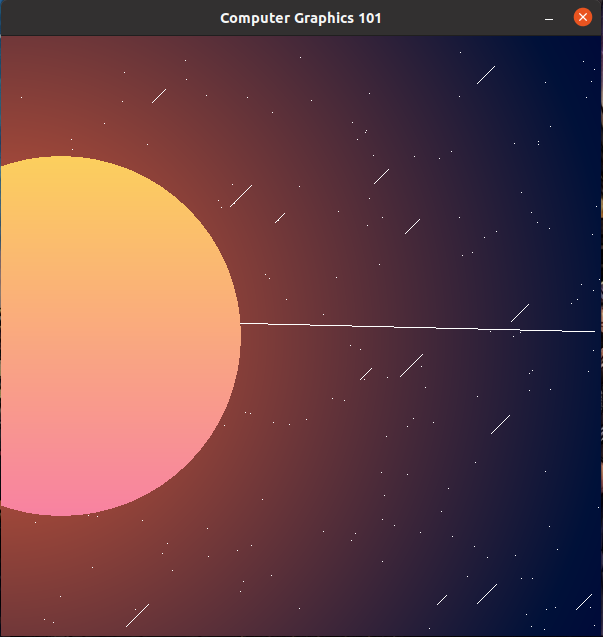